In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import EntropyRateSuperpixel as ERS
import MyDataset as Data
import LambdaCoeff as LC

import SSGA

145 145 200


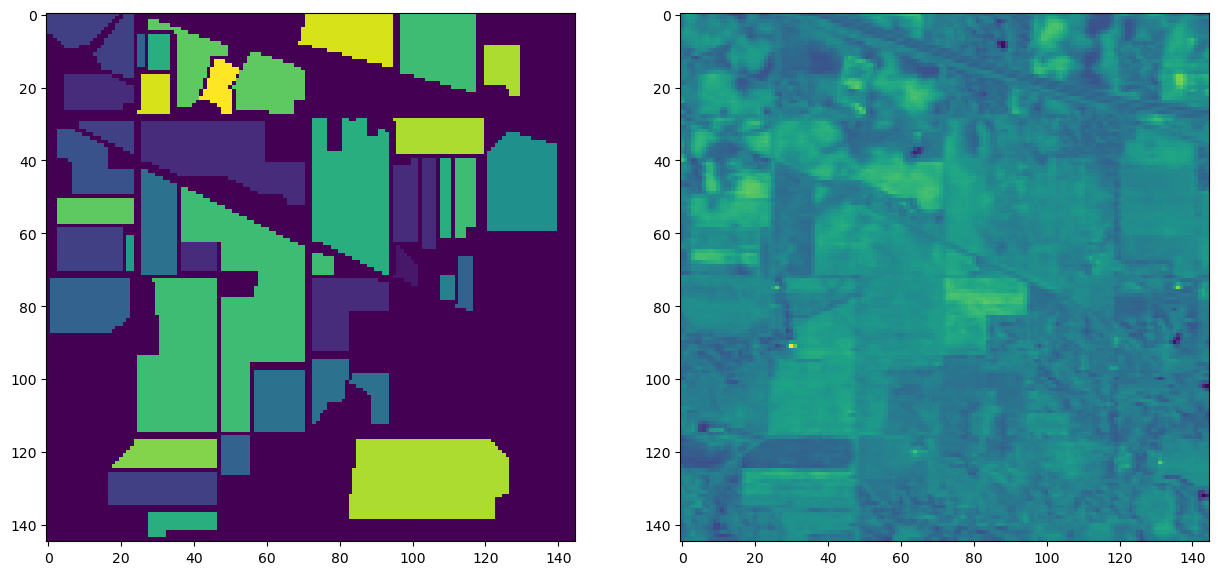

In [2]:
usedDataset = Data.IndianPines
#usedDataset = Data.PaviaUniversity
#usedDataset = Data.PaviaCenter


N,M,B = usedDataset["shape"]
trainData = usedDataset["data"]
print(N,M,B)
trainData = Data.standardize_data(trainData)

fig, axs = plt.subplots(1, 2, figsize=(15,10))
axs[0].imshow(usedDataset["gt"])
axs[1].imshow(np.average(usedDataset["data"], axis=2))
plt.show()

### Choice of Ks

In [70]:
Ks = [10, 20, 40, 80, 160, 320, 640, 1280]
Ks.sort()

### Compute SPs

In [46]:
SPsDic = ERS.find_superpixel(trainData, Ks,
                             lambda_coef="auto",
                             simFun="norm1")

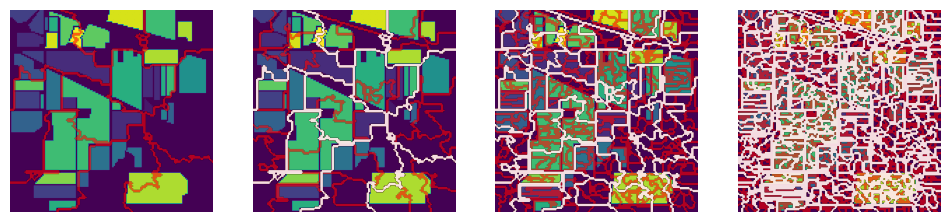

In [51]:
n,m = 1,4
Ks_id_to_plot = np.unique(np.round(np.linspace(0,len(Ks)-1, n*m)).astype(int))
Ks2D = np.array([Ks[i] for i in Ks_id_to_plot]).reshape(n,m)

fig, axs = plt.subplots(n, m, figsize=(12,6))
axs = axs.reshape(n,m)
for i in range(n):
    for j in range(m):
        axs[i,j].axis("off")
        axs[i,j].imshow(usedDataset["gt"])
        axs[i,j].imshow(ERS.create_overlay_borders(usedDataset["gt"], SPsDic[Ks2D[i,j]], color=[255,0,0,150]))
        if i+j>0:
            pred = (i,j-1) if j>0 else (i-1, m-1)
            axs[i,j].imshow(ERS.create_overlay_borders(usedDataset["gt"], SPsDic[Ks2D[pred]], color=[255,255,255,220]))
        
plt.show()

In [99]:
associations = np.zeros((len(Ks), N, M), dtype=int)
for level, K in enumerate(Ks):
    SPs = SPsDic[K]
    for k,SP in enumerate(SPs):
        for x,y in SP:
            associations[level][x,y] = k


def getSP(level, idSP):
    return SPsDic[Ks[level]][idSP]

highToLow = [[None for _ in range(len(SPsDic[K]))] for K in Ks]
for level in range(1,len(Ks)):
    for k, SP in enumerate(SPsDic[Ks[level]]):
        highToLow[level][k] = associations[level-1][SP[0]]


lowToHigh = [[[] for _ in range(len(SPsDic[K]))] for K in Ks]
for level in range(1, len(Ks)):
    SPs = SPsDic[Ks[level]]
    for k, SP in enumerate(SPs):
        botId = highToLow[level][k]
        lowToHigh[level-1][botId] += [k]

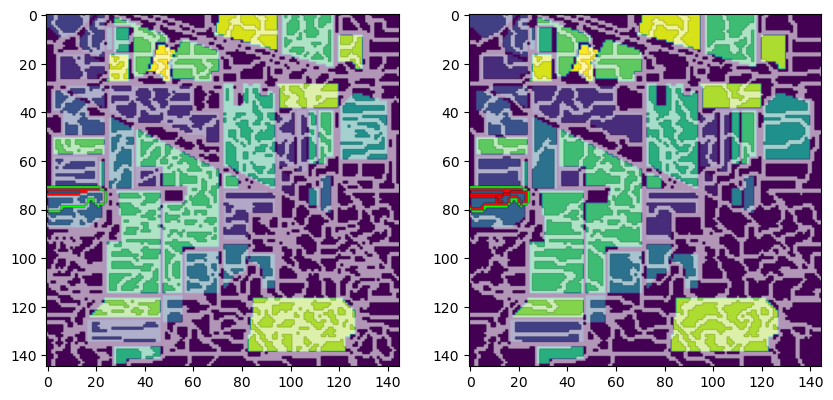

In [114]:
level = np.random.randint(1, len(Ks)-1)
idSP = np.random.randint(0, len(SPsDic[Ks[level]])-1)
SP = getSP(level, idSP)
parentID = highToLow[level][idSP]
parent = getSP(level-1, parentID)
childs = [getSP(level, id) for id in lowToHigh[level-1][parentID]]

fig, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].imshow(usedDataset["gt"])
axs[0].imshow(ERS.create_overlay_borders(usedDataset["gt"], SPsDic[Ks[level]], color=[255,255,255,150]))
axs[0].imshow(ERS.create_overlay_borders(usedDataset["gt"], [SP], color=[255,0,0,250]))
axs[0].imshow(ERS.create_overlay_borders(usedDataset["gt"], [parent], color=[0,255,0,250], exterior=True))

axs[1].imshow(usedDataset["gt"])
axs[1].imshow(ERS.create_overlay_borders(usedDataset["gt"], SPsDic[Ks[level-1]], color=[255,255,255,150]))
for child in childs:
    axs[1].imshow(ERS.create_overlay_borders(usedDataset["gt"], [child], color=[255,0,0,250]))
axs[1].imshow(ERS.create_overlay_borders(usedDataset["gt"], [parent], color=[0,255,0,250], exterior=True))
plt.show()